### This notebook is dedicated to investigating different methods applying TWSA from GRACE and GRACE-FO to obtain the time derivatives of TWSA. The results will be used in monitoring extreme events such as floods and droughts in the Greater Horn of Africa region.
Author: S. Karimi Feb 2024 (s.karimi@utwente.nl)

# Read data

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
data_dir= "output"
twsa_netcdf= 'twsa_nileregion.nc'
fullpath= os.path.join(data_dir, twsa_netcdf)
print(fullpath)

output/twsa_nileregion.nc


In [3]:
ds = xr.open_dataset(fullpath) # load TWSA of Nile watershed obtained from grid-tws-finalversion 

# Time derivatives of TWS anomalies

As an example, the computations are applied to the TWSA obtained from the filtered version of GRACE/GRACE-FO observations using the DDK5 filter. It is also possible to apply these steps to both unfiltered data and data filtered using the Gaussian filter.

# Bspline smoothing

We create an approximation of the TWSA time series from GRCAE/GRACE-FO using the Bspline smoothing method. The advantage of this method is that it does not require passing from all data points of GRACE and GRACE_FO observations, which are noisy.

The approximated version is indicated for GRACE-FO time series.

In [4]:
from scipy.interpolate import splrep, BSpline # source: https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html

In [5]:
## Applying B Spline functions on GRACE-FO time series.

import pandas as pd

tt = ['2017-12-12T23:59:59.500000000', '2018-06-27T23:59:59.500000000']

# strings to datetime objects
tt_datetime = [pd.to_datetime(t) for t in tt]

# Convert tws['time'] to datetime objects
tws_datetime = pd.to_datetime(ds['time'])

# Create the mask using datetime objects
mask1 = (tws_datetime < tt_datetime[0])
mask_dict1 = {'time': mask1}

mask2 = (tws_datetime > tt_datetime[1])
mask_dict2 = {'time': mask2}

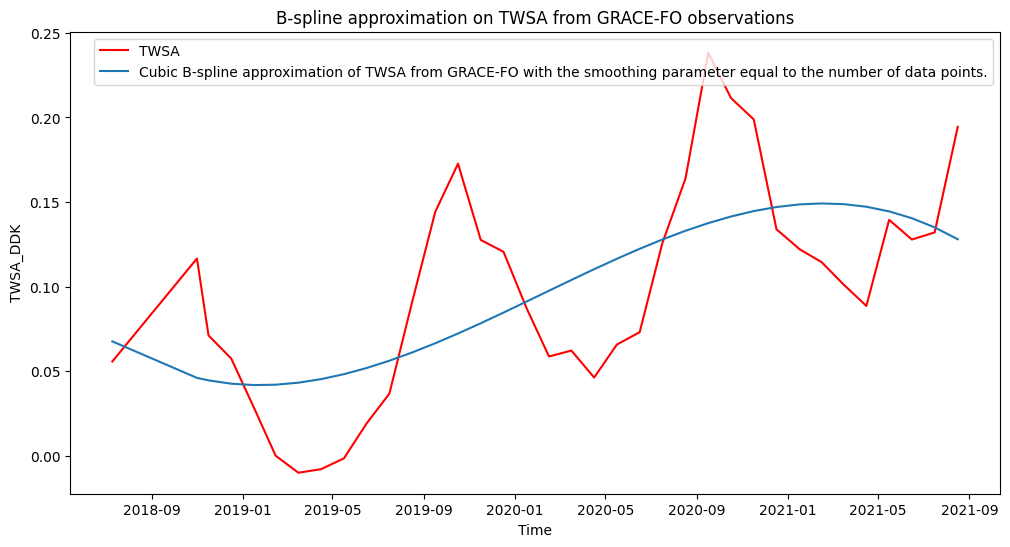

In [6]:
GRACE_FO_TWSA = ds.sel(**mask_dict2)
time_FO = GRACE_FO_TWSA['time'].values
time_integer_FO = (time_FO - time_FO[0]) / np.timedelta64(1, 'D')
smoothing_level= len(GRACE_FO_TWSA['time'])
tck = splrep(time_integer_FO, GRACE_FO_TWSA['ddk'].values, k=3, s = smoothing_level)

# Extracting knots, coefficients, and degree from tck
knots, coefficients, degree = tck

# Creating a BSpline object
bspline = BSpline(knots, coefficients, degree)

dsdt_ddk_FO = bspline(time_integer_FO)

plt.figure(figsize=(12, 6))
plt.plot(time_FO, GRACE_FO_TWSA['ddk'].values, 'r-', label='TWSA')
plt.plot(time_FO, dsdt_ddk_FO, '-', label='Cubic B-spline approximation of TWSA from GRACE-FO with the smoothing parameter equal to the number of data points.')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('TWSA_DDK')
plt.title('B-spline approximation on TWSA from GRACE-FO observations')
plt.show()

The same steps is applied on the whole time series of GRACE/GRACE-FO as below:

In [7]:
time_bs = ds['time'].values
ddk_bs = ds['ddk'].values
time_integer_bs = (time_bs - time_bs[0]) / np.timedelta64(1, 's')

In [11]:
smoothing_level= len(ds['time'])
tck = splrep(time_integer_bs, ddk_bs, k=3, s = smoothing_level) #s= 0.001 piecewise spline - k is the order for bsplines from 1 to 5 3 #degree = 3 is the Cubic B-spline with 12 coefficients

#y_new = splev(x_new, tck, der=0) ## Note that this line is equivalent to BSpline(*tck)(xnew).


# Extracting knots, coefficients, and degree from tck
knots, coefficients, degree = tck

# Creating a Bspline object with BSpline class 
bspline = BSpline(knots, coefficients, degree)

#time_new = np.linspace(time_month.min(), time_month.max(), 200)
#ddk_new = bspline(time_new)

dsdt_ddk_bs = bspline(time_integer_bs)

In [12]:
bspline_dr=bspline.derivative()
dsdt_timederivative= bspline_dr(time_integer_bs)

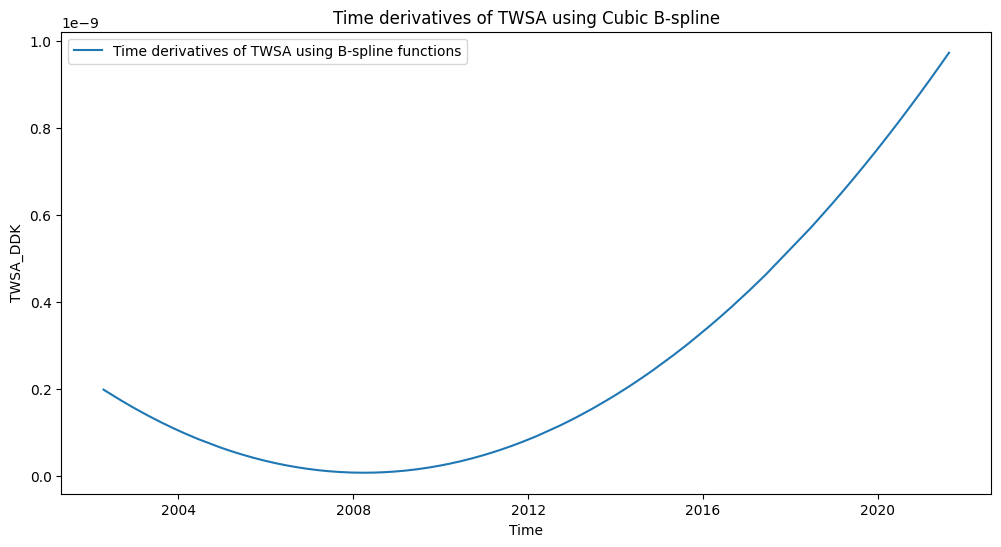

In [13]:
#time_new_datetime = np.array([np.datetime64('2002-04') + np.timedelta64(int(m), 'M') for m in time_new])

# Plotting
plt.figure(figsize=(12, 6))
#plt.plot(time_integer, ddk, 'r-', label='TWSA')
#plt.plot(time_integer, dsdt_ddk, '-', label='Time derivatives of TWSA using B-spline functions')
plt.plot(ds['time'], dsdt_timederivative, '-', label='Time derivatives of TWSA using B-spline functions')

plt.legend()
plt.xlabel('Time')
plt.ylabel('TWSA_DDK')
plt.title('Time derivatives of TWSA using Cubic B-spline')
plt.show()


Next: remove annual variations to only have inter annual variations before applying the bspline
method: ls will fit cosin and sin functions- read relevant articles
change the unit to later compare with other models
all steps should be applied before bspline modeling


# Comparing with other methods

# Backwards difference approximation

In [14]:
def calculate_ds(TWS, delta_t):
    
    
        #for i in range(1, len(TWS.time) - 1):
        #cntws = (TWS.isel(time=i+1) - TWS.isel(time=i-1)) / (2 * delta_t)
       # cntws_values.append(cntws)

    TWS_diff = TWS.diff(dim='time') / delta_t
    time_values = TWS.time[1:]
    #diff.append(TWS_diff)

    return TWS_diff,time_values


In [15]:
delta_t = 1  

#middle_times = calculate_time(ds, delta_t)

ds_tws, time_values= calculate_ds(ds.tws, delta_t)
ds_gauss, time_values= calculate_ds(ds.gauss, delta_t)
ds_ddk, time_values= calculate_ds(ds.ddk, delta_t)

#ds_tws= calculate_ds(ds.tws, delta_t).data
#ds_gauss= calculate_ds(ds.gauss, delta_t).data
#ds_ddk= calculate_ds(ds.ddk, delta_t).data



#dsdt = xr.DataArray(diffi, coords={'time': middle_times}, dims=['time'])

dsdt_backward_differences = xr.Dataset({'ds_tws_bw': (('time',), ds_tws.values), 'ds_gauss_bw': (('time',), ds_gauss.values), 'ds_ddk_bw': (('time',), ds_ddk.values)}, coords={'time_bw': time_values.values})

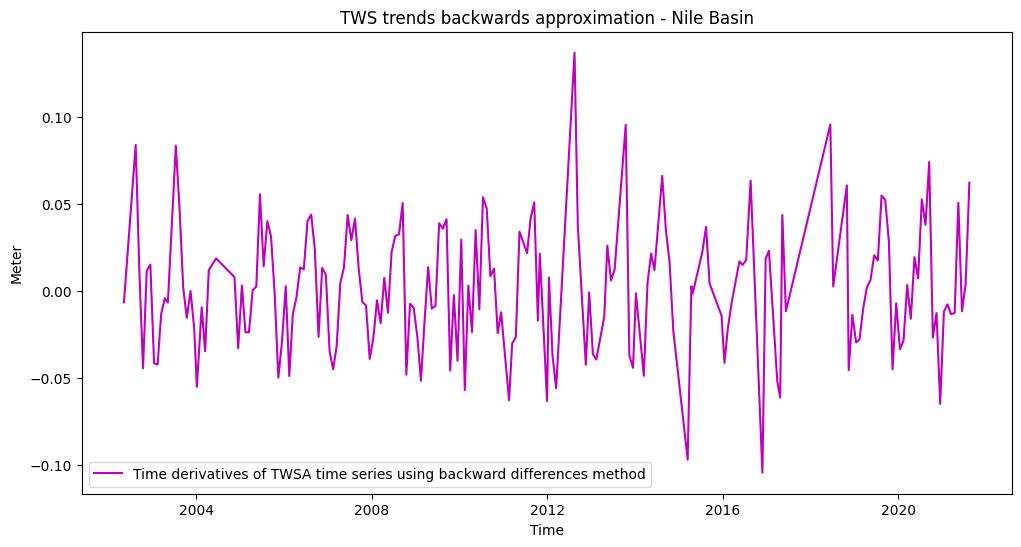

In [16]:
plt.figure(figsize=(12,6))
plt.plot(dsdt_backward_differences['time_bw'],dsdt_backward_differences ['ds_ddk_bw'],'m-',label='Time derivatives of TWSA time series using backward differences method')
plt.xlabel('Time')
plt.ylabel('Meter')
plt.title('TWS trends backwards approximation - Nile Basin')
plt.legend()
#plt.xticks(rotation=45)

plt.show()

# Centred differences approximation

In [17]:
def centered_tws(TWS, delta_t):
    cntws_values = []
    for i in range(1, len(TWS.time) - 1):
        cntws = (TWS.isel(time=i+1) - TWS.isel(time=i-1)) / (2 * delta_t)
        cntws_values.append(cntws)
        
    #time_values = xr.concat(cntws_values, dim='time')
    #time_values = time_values.assign_coords(time=ds.tws.time[1:-1].values)
    time_values = TWS.time[1:-1]
   
    return cntws_values, time_values

In [18]:
ds_tws1,time_values= centered_tws(ds.tws, delta_t)

ds_ddk1,time_values= centered_tws(ds.ddk, delta_t)
ds_gauss1,time_values= centered_tws(ds.gauss, delta_t)


dsdt_centered_differences = xr.Dataset({'ds_tws_cd': (('time',), ds_tws1), 'ds_gauss_cd': (('time',), ds_gauss1), 'ds_ddk_cd': (('time',), ds_ddk1)}, coords={'time_cd': time_values.values})

#ds_tws2 = xr.DataArray(Vads_tws1, dims='time', coords={'time': time_values})

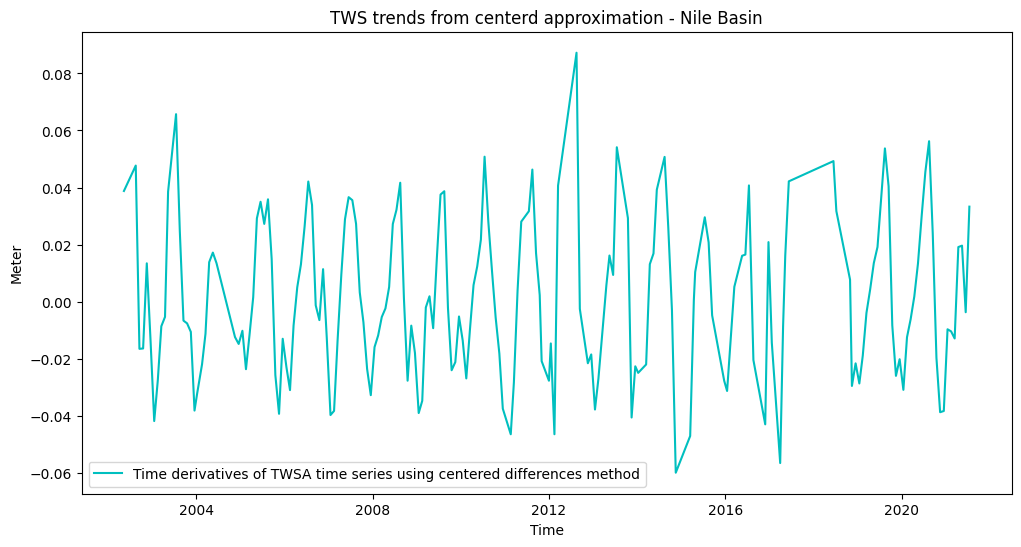

In [19]:
plt.figure(figsize=(12,6))
plt.plot(dsdt_centered_differences['time_cd'],dsdt_centered_differences ['ds_ddk_cd'],'c-',label='Time derivatives of TWSA time series using centered differences method')

plt.xlabel('Time')
plt.ylabel('Meter')
plt.title('TWS trends from centerd approximation - Nile Basin')
plt.legend()
#plt.xticks(rotation=45)

plt.show()

# Comparing three methods 

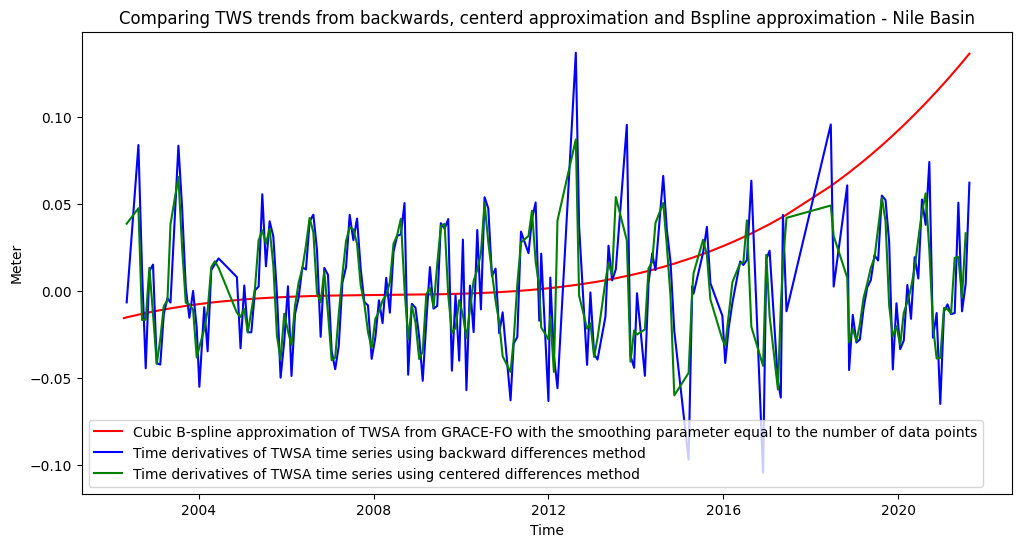

In [20]:
plt.figure(figsize=(12,6))
plt.plot(ds['time'], dsdt_ddk_bs, 'r-', label='Cubic B-spline approximation of TWSA from GRACE-FO with the smoothing parameter equal to the number of data points')
plt.plot(dsdt_backward_differences['time_bw'],dsdt_backward_differences ['ds_ddk_bw'],'b-',label='Time derivatives of TWSA time series using backward differences method')
plt.plot(dsdt_centered_differences['time_cd'],dsdt_centered_differences ['ds_ddk_cd'],'g-',label='Time derivatives of TWSA time series using centered differences method')

plt.xlabel('Time')
plt.ylabel('Meter')
plt.title('Comparing TWS trends from backwards, centerd approximation and Bspline approximation - Nile Basin')
plt.legend(loc='best')
#plt.xticks(rotation=45)

plt.show()

# Conclusion

The Centered method results in a smoother rate than the backward method. However, both backwards and centered differences methods do not indicate the effect of the significant increase in TWSA from 2019 to 2021 in the TWSA time series obtained from GRACE-FO observations. This limitation can be due to high noise levels present in GRACE/GRACE-FO observations after filtering, which indicates that a higher level of smoothing is still required. 

In contrast, the Bspline method yields a smoother, more robust, and less noisy signal.

As a result, it is recommended to approximate the TWSA time series using cubic B-spline functions.